In [3]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

MODEL_NAME = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)


def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)

def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
#tfdataset = construct_tfdataset(encodings, y)
    
#encodings = construct_encodings(x, tokenizer, max_len=MAX_LEN)

In [4]:
import pandas as pd
import random 

random.seed(1)

seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

test_index = random.sample(set(r_index), 250)
train_index = seen_index.difference(test_index)

(2629, 251)


In [6]:
train_index = random.sample(list(train_index), 20)
test_index = random.sample(test_index, 20)

4.228571428571429


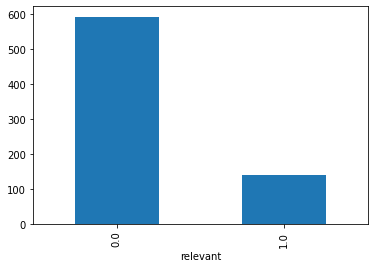

In [7]:
seen_df[seen_df['random_sample']==1].groupby('relevant').size().plot.bar()
cw = seen_df[(seen_df['random_sample']==1) & (seen_df['relevant']==0)].shape[0] / seen_df[(seen_df['random_sample']==1) & (seen_df['relevant']==1)].shape[0]
class_weight={0:1, 1:cw}
print(cw)

In [8]:
train_encodings = tokenizer(list(df['content'][train_index].values),
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(list(df['content'][test_index].values),
                            truncation=True,
                            padding=True)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(df['relevant'][train_index].values)
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    #list(df['relevant'][test_index].values)
))

MAX_LEN = train_dataset._structure[0]['input_ids'].shape[0]

In [11]:
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

#model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
#model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=[tf.keras.metrics.AUC])
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [12]:
model.fit(train_dataset.shuffle(100).batch(16),
          epochs=2,
          batch_size=16,
          class_weight=class_weight
          )

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fa8445de2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fa8445de2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2/2 [==============================] - 27s 4s/step - loss: 2.2192 - binary_accuracy: 0.3583
Epoch 2/2
2/2 [==============================] - 17s 4s/step - loss: 1.7674 - binary_accuracy: 0.3917


In [19]:
preds = model.predict(val_dataset.batch(1)).logits
preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()
preds.shape

(20, 1)

In [18]:
def create_predictor(model, model_name, max_len):
    def predict_proba(text):
        x = text

        
        tfdataset = val_dataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()
        return preds#[0][0]

    return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)
y_pred = clf(list(df['content'][test_index].values))

array([[0.41530976],
       [0.4362556 ],
       [0.44930917],
       [0.43645823],
       [0.4440166 ],
       [0.44288683],
       [0.4416364 ],
       [0.45262742],
       [0.42559588],
       [0.43522677],
       [0.43112153],
       [0.4399997 ],
       [0.44332913],
       [0.44636872],
       [0.42129672],
       [0.44079742],
       [0.44306153],
       [0.42995054],
       [0.42663085],
       [0.42598927]], dtype=float32)

In [15]:
tfdataset = val_dataset.batch(1)
preds = model.predict(val_dataset).logits
preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()

preds.shape

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


(10240, 1)

In [110]:
minitest = [
    'Oceanic phytoplankton respond rapidly to a complex spectrum of climate-driven perturbations, confounding attempts to isolate the principal causes of observed changes. A dominant mode of variability in the Earth-climate system is that generated by the El Nino phenomenon. Marked variations are observed in the centroid of anomalous warming in the Equatorial Pacific under El Nino, associated with quite different alterations in environmental and biological properties. Here, using observational and reanalysis datasets, we differentiate the regional physical forcing mechanisms, and compile a global atlas of associated impacts on oceanic phytoplankton caused by two extreme types of El Nino. We find robust evidence that during Eastern Pacific (EP) and Central Pacific (CP) types of El Nino, impacts on phytoplankton can be felt everywhere, but tend to be greatest in the tropics and subtropics, encompassing up to 67% of the total affected areas, with the remaining 33% being areas located in high-latitudes. Our analysis also highlights considerable and sometimes opposing regional effects. During EP El Nino, we estimate decreases of -56 TgC/y in the tropical eastern Pacific Ocean, and -82 TgC/y in the western Indian Ocean, and increase of +13 TgC/y in eastern Indian Ocean, whereas during CP El Nino, we estimate decreases -68 TgC/y in the tropical western Pacific Ocean and -10 TgC/y in the central Atlantic Ocean. We advocate that analysis of the dominant mechanisms forcing the biophysical under El Nino variability may provide a useful guide to improve our understanding of projected changes in the marine ecosystem in a warming climate and support development of adaptation and mitigation plans.',
    "Increasing atmospheric CO2 is raising sea surface temperature (SST) and increasing seawater CO2 concentrations, resulting in a lower oceanic pH (ocean acidification; OA), which is expected to reduce the accretion of coral reef ecosystems. Although sediments comprise most of the calcium carbonate (CaCO3) within coral reefs, no in situ studies have looked at the combined effects of increased SST and OA on the dissolution of coral reef CaCO3 sediments. In situ benthic chamber incubations were used to measure dissolution rates in permeable CaCO3 sands under future OA and SST scenarios in a coral reef lagoon on Australia's Great Barrier Reef (Heron Island). End of century (2100) simulations (temperature +2.7°C and pH -0.3) shifted carbonate sediments from net precipitating to net dissolving. Warming increased the rate of benthic respiration (R) by 29% per 1°C and lowered the ratio of productivity to respiration (P/R; ΔP/R = -0.23), which increased the rate of CaCO3 sediment dissolution (average net increase of 18.9 mmol CaCO3 m-2 d-1 for business as usual scenarios). This is most likely due to the influence of warming on benthic P/R which, in turn, was an important control on sediment dissolution through the respiratory production of CO2. The effect of increasing CO2 on CaCO3 sediment dissolution (average net increase of 6.5 mmol CaCO3 m-2 d-1 for business as usual scenarios) was significantly less than the effect of warming. However, the combined effect of increasing both SST and pCO2 on CaCO3 sediment dissolution was non-additive (average net increase of 5.6 mmol CaCO3 m-2 d-1) due to the different responses of the benthic community. This study highlights that benthic biogeochemical processes, such as metabolism and associated CaCO3 sediment dissolution respond rapidly to changes in SST and OA, and that the response to multiple environmental changes are not necessarily additive. © 2016 Trnovsky, Stoltenberg, Cyronak and Eyre.",
    "A fundamentally revised version of the HERMES agro-ecosystem model, released under the name of MONICA, was calibrated and tested to predict crop growth, soil moisture and nitrogen dynamics for various experimental crop rotations across Germany, including major cereals, sugar beet and maize. The calibration procedure also included crops grown experimentally under elevated atmospheric CO2 concentration. The calibrated MONICA simulations yielded a median normalised mean absolute error (nMAE) of 0.20 across all observed target variables (n = 42) and a median Willmott's Index of Agreement (d) of 0.91 (median modelling efficiency (ME): 0.75). Although the crop biomass, habitus and soil moisture variables were all within an acceptable range, the model often underperformed for variables related to nitrogen. Uncalibrated MONICA simulations yielded a median nMAE of 0.27 across all observed target variables (n = 85) and a median d of 0.76 (median ME: 0.30), also showing predominantly acceptable results for the crop biomass, habitus and soil moisture variables. Based on the convincing performance of the model under uncalibrated conditions, MONICA can be regarded as a suitable simulation model for use in regional applications. Furthermore, its ability to reproduce the observed crop growth results in free-air carbon enrichment experiments makes it suited to predict agro-ecosystem behaviour under expected future climate conditions. (C) 2011 Elsevier B.V. All rights reserved."
]

In [113]:

def create_predictor(model, model_name, max_len):
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    def predict_proba(text):
        x = text

        encodings = construct_encodings(x, tkzr, max_len=max_len)
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()
        return preds#[0][0]

    return predict_proba

clf = create_predictor(model, MODEL_NAME, MAX_LEN)
y_pred = clf(list(df['content'][test_index].values))

In [123]:
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score

def evaluate_preds(y_true, y_pred):
    roc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred.round())
    p, r = precision_score(y_true, y_pred.round()), recall_score(y_true, y_pred.round())
    acc = accuracy_score(y_true, y_pred.round())
    
    print(f"ROC AUC: {roc:.0%}, F1: {f1:.1%}, precision: {p:.1%}, recall {r:.1%}, acc {acc:.0%}")
    return {"ROC AUC": roc, "F1": f1, "precision": p, "recall": r, "accuracy": acc}

evaluate_preds(df['relevant'][test_index], y_pred[:,0])

ROC AUC: 90%, F1: 72.9%, precision: 74.5%, recall 71.4%, acc 90%


{'ROC AUC': 0.8971469184688801,
 'F1': 0.7291666666666666,
 'precision': 0.7446808510638298,
 'recall': 0.7142857142857143,
 'accuracy': 0.896}

In [10]:
model.save_pretrained("models/binary_model")

In [109]:
df.loc[(df['relevant']==0)&(df.index.isin(test_index)),'content'].values[1]

"A fundamentally revised version of the HERMES agro-ecosystem model, released under the name of MONICA, was calibrated and tested to predict crop growth, soil moisture and nitrogen dynamics for various experimental crop rotations across Germany, including major cereals, sugar beet and maize. The calibration procedure also included crops grown experimentally under elevated atmospheric CO2 concentration. The calibrated MONICA simulations yielded a median normalised mean absolute error (nMAE) of 0.20 across all observed target variables (n = 42) and a median Willmott's Index of Agreement (d) of 0.91 (median modelling efficiency (ME): 0.75). Although the crop biomass, habitus and soil moisture variables were all within an acceptable range, the model often underperformed for variables related to nitrogen. Uncalibrated MONICA simulations yielded a median nMAE of 0.27 across all observed target variables (n = 85) and a median d of 0.76 (median ME: 0.30), also showing predominantly acceptable 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np

df = pd.read_csv('../data/0_labelled_documents.csv')
df = (df
      .query('unlabelled==0')
      .query('relevant==1')
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)#.head(500)


targets = [x for x in df.columns if "12 - " in x and "Physical systems" not in x]
df['labels'] = list(df[targets].values)
class_weight = {}
for i, t in enumerate(targets):
    cw = df[(df['random_sample']==1) & (df[t]==0)].shape[0] / df[(df['random_sample']==1) & (df[t]==1)].shape[0]
    class_weight[i] = cw

class_weight
y = np.matrix(df[targets])



In [47]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.multiclass import OneVsRestClassifier

def KFoldRandom(n_splits, X, no_test, shuffle=False, discard=True):
    kf = KFold(n_splits=n_splits, shuffle=shuffle)
    for train, test in kf.split(X):
        if not discard:
            train = list(train) +  [x for x in test if x in no_test]
        test = [x for x in test if x not in no_test]
        yield (train, test)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

targets = [x for x in df.columns if "12 - " in x and "Physical systems" not in x]
df['labels'] = list(df[targets].values)
class_weight = {}
for i, t in enumerate(targets):
    cw = df[(df['random_sample']==1) & (df[t]==0)].shape[0] / df[(df['random_sample']==1) & (df[t]==1)].shape[0]
    class_weight[i] = cw

class_weight
y = np.matrix(df[targets])

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SVC(probability=True))),
])


parameters = [
    {
	'vect__max_df': (0.5,),
        'vect__min_df': (10,),
        'vect__ngram_range': ((1, 1),),
        'clf__estimator__kernel': ['rbf'],
	'clf__estimator__gamma': [1e-3,],
        'clf__estimator__C': [1,],
        'clf__estimator__class_weight': [None, "balanced"]
    },
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (10,),
        'vect__ngram_range': ((1, 1),),
        'clf__estimator__kernel': ['linear'],
	'clf__estimator__C': [1,]
    }
]

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

outer_cv = KFoldRandom(3, df.index, df[df['random_sample']!=1].index, discard=False)
outer_scores = []
clfs = []


In [48]:
rank_i = 0

for k, (train, test) in enumerate(outer_cv):
    if k!=rank_i:
        continue
    inner_cv = KFoldRandom(3, train, df[df['random_sample']!=1].index, discard=False)
    clf = GridSearchCV(pipeline, parameters, scoring="f1_macro", n_jobs=8, verbose=1, cv=inner_cv)
    clf.fit(df.loc[train, 'content'], y[train])


Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [36]:
revectorize = True

import os
import pickle 

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(1341, 12721)

In [42]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True), class_weight=class_weight)
clf.fit(X,y)

TypeError: __init__() got an unexpected keyword argument 'class_weight'

In [43]:
clf = SVC(kernel='linear', probability=True, multi_class="ovr", class_weight=class_weight)
clf.fit(X,y)

TypeError: __init__() got an unexpected keyword argument 'multi_class'